<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-4/4th_custom_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **4th File: Custom Loss Fn**
    - Tuned Batch Size
    - Custom Loss Function
    - SpatialDropout2D
    
 [SpatialDropout2D](https://github.com/keras-team/keras/blob/master/keras/layers/core.py#L178)
    
    Our custom loss function has two objectives, 
    1. Make different filters un-correlated, so that we find varying features, more than one filter is not used for same feature.
    2. Make the filters smooth
 [Translation Invariance is due to smooth filters](http://principlesofdeeplearning.com/index.php/2018/08/27/is-pooling-dead-in-convolutional-networks/).
 
**Note**: Results from custom loss function are inconclusive. We may need a bigger dataset and larger network to test this. Also SpatialDropout2D may serve the same goal as our custom loss fn.

**Winner:** Architecture 3 is a winner with 12846 params and 99.5%

**Winner 2:** Architecture 16 with our custom loss and 4430 params, 99.4%

Also we noticed that reduce_lr and early_stopping don't help much. early_stopping only helps reduce epochs.
    


In [0]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null

In [2]:
import pandas as pd
import numpy as np
import time
import gc
import os
import sys
import dill
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, SpatialDropout2D
from keras.layers import Convolution2D, MaxPooling2D
import warnings
from data_science_utils.vision.keras import *
from keras.layers import Activation
warnings.filterwarnings("ignore")
%matplotlib inline
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import SGD, Nadam, Adam
import tensorflow_probability as tfp
import tensorflow as tf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:

X_train, Y_train, X_test, Y_test = get_mnist_data()
print(X_train.shape)
print(X_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Defining a new Loss Fn


In [0]:
def view_layer_filter_stats(layer_index,diversity_clipping=0.01):
  sess = K.get_session()
  layer = model.layers[0]
  weights = layer.get_weights()[0]
  
  num_filters = weights.shape[3]
  num_in_channels = weights.shape[2]
  weights = weights.reshape((-1,num_filters))

  lower_coer_limit = K.constant(diversity_clipping)
  negative_coer_limit = K.constant(-diversity_clipping)

  bm = np.abs(weights.mean(axis=0))
  bstd = weights.std(axis=0)
  coer = tfp.stats.correlation(weights, sample_axis=0, event_axis=-1)
  smoothness_df = pd.DataFrame({"std":bstd,"std_by_mean":bstd/bm,"mean":bm})
  mask = tf.math.logical_or(tf.math.greater(coer,lower_coer_limit),tf.math.less(coer,negative_coer_limit))
  coer_loss = K.sum(K.abs(tf.boolean_mask(coer,mask)))
  coer_loss = coer_loss/(num_filters*num_filters*num_in_channels)
  smooth_loss = np.sum(smoothness_df["std_by_mean"])
  smooth_loss = smooth_loss/num_filters
  coer_loss = sess.run(coer_loss)
  return smooth_loss,coer_loss,smoothness_df




In [0]:
from keras.losses import categorical_crossentropy
import tensorflow_probability as tfp
import tensorflow as tf
def get_smoothness_loss(model):
  conv_layers = [layer for layer in model.layers if type(layer)==Convolution2D and layer.trainable_weights[0].shape.as_list()[0]>0]
  conv_layers = conv_layers[:-1]
  def smoothness_loss(y_true, y_pred):
    total_loss = K.variable(0)
    for layer in conv_layers:
      p_loss = K.variable(0)
      weights = layer.trainable_weights[0]
      shape = layer.trainable_weights[0].shape.as_list()
      num_filters = shape[3]
      weights = K.reshape(weights,(-1,num_filters))
      stds = K.std(weights,axis=0)
      means = K.abs(K.mean(weights,axis=0))
      p_loss = K.sum(stds/means)
      p_loss = p_loss/num_filters
      total_loss = total_loss + p_loss
    return total_loss/len(conv_layers)
  return smoothness_loss

def get_diversity_loss(model,diversity_clipping=0.1,):
  conv_layers = [layer for layer in model.layers if type(layer)==Convolution2D and layer.trainable_weights[0].shape.as_list()[0]>0]
  conv_layers = conv_layers[:-1]
  def diversity_loss(y_true, y_pred):
    lower_coer_limit = K.constant(diversity_clipping)
    negative_coer_limit = K.constant(-diversity_clipping)
    total_loss = K.variable(0)
    for layer in conv_layers:
      p_loss = K.variable(0)
      weights = layer.trainable_weights[0]
      shape = layer.trainable_weights[0].shape.as_list()
      num_filters = shape[3]
      num_in_channels = shape[2]
      weights = K.reshape(weights,(-1,num_filters))
      coer = tfp.stats.correlation(weights, sample_axis=0, event_axis=-1)
      # mask = tf.math.logical_or(tf.math.greater(coer,lower_coer_limit),tf.math.less(coer,negative_coer_limit))
      # p_loss = K.sum(K.abs(tf.boolean_mask(coer,mask)))
      
      mask = tf.math.greater(coer,lower_coer_limit)
      p_loss = K.sum(tf.boolean_mask(coer,mask))
      
      p_loss = p_loss/(num_filters*num_filters*num_in_channels)
      total_loss = total_loss + p_loss
    return total_loss/len(conv_layers)
  return diversity_loss
        
  
def combined_smoothness_diversity_loss(model,loss_fn,loss_fn_constant,batch_size,total_data_size,
                                       diversity_constant,smoothness_constant,
                                       diversity_clipping=0.1,
                                       diversity_decay=None, smoothness_decay=None,):
  dvl = get_diversity_loss(model,diversity_clipping=diversity_clipping)
  sml = get_smoothness_loss(model)
  iters_per_epoch = int(np.ceil(total_data_size/batch_size))
  # n^(iters_per_epoch*diversity_decay)=0.1
  # np.log(n) = np.log(0.1)/(iters_per_epoch*diversity_decay)
  # n = np.exp(np.log(0.1)/(iters_per_epoch*diversity_decay))
  if diversity_decay is not None and diversity_decay > 1:
    dd_const = K.constant(np.exp(np.log(0.1)/(iters_per_epoch*diversity_decay)))
  else:
    dd_const = K.constant(1)
    
  if smoothness_decay is not None and smoothness_decay > 1:
    sd_const = K.constant(np.exp(np.log(0.1)/(iters_per_epoch*smoothness_decay)))
  else:
    sd_const = K.constant(1)
  dd = K.variable(diversity_constant)
  sd = K.variable(smoothness_constant)
  container ={"dd":dd,"sd":sd}
  loss_fn_constant = K.constant(loss_fn_constant)
  sess = K.get_session()
    
  def combined_loss(y_true, y_pred):
    cc_loss = loss_fn_constant*loss_fn(y_true, y_pred)
    
    dv_loss = dvl(y_true, y_pred)
    sm_loss = sml(y_true, y_pred)
    
    dv_loss = container["dd"]*dv_loss
    sm_loss = container["sd"]*sm_loss
    container["dd"] = container["dd"] * dd_const
    container["sd"] = container["sd"] * sd_const
    # print(sess.run(dv_loss),sess.run(sm_loss))
    return cc_loss + dv_loss + sm_loss
  return combined_loss
    
    

## Architecture 3

We tried 32 in 1st layer and then noticed that many of these kernels were empty. So we will use dropout to add more robustness

### With Custom Loss

In [19]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=15,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss=combined_smoothness_diversity_loss(model,categorical_crossentropy,1,512,X_train.shape[0],
                                       diversity_constant=0.0001,smoothness_constant=0,
                                       diversity_clipping=0.1,
                                       diversity_decay=5, smoothness_decay=None,),
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=512, epochs=50, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)



Params =  12846

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0001.
Layer Names:  ['conv2d_55', 'dropout_33', 'conv2d_56', 'conv2d_57', 'dropout_34', 'max_pooling2d_9', 'conv2d_58', 'dropout_35', 'conv2d_59', 'dropout_36', 'conv2d_60', 'dropout_37', 'conv2d_61', 'conv2d_62', 'flatten_8', 'activation_8']
Validation Loss (0.020829086902737617, 0.9941999999046326)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  12846
Score =  [0.004812731390500751, 0.9989333333333333]
Balanced Accuracy = 99.89% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-

Compute filters 0 to 32
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 32 filter processed.
Filter Losses:  [5.4625273, 3.3270907, 6.157343, 3.6686928, 5.8007402, 3.349158, 5.0328183, 4.55074, 0.0, 9.023438, 5.794366, 2.8923936, 4.74861, 4.015097, 7.8553886, 3.8771951, 3.835338, 0.0, 0.0, 3.7973228, 0.0, 10.848156, 2.5926235, 4.3794947, 7.4504495, 4.7477465, 6.5080023, 0.0, 3.1117194, 5.5247636, 0.0, 10.385069]


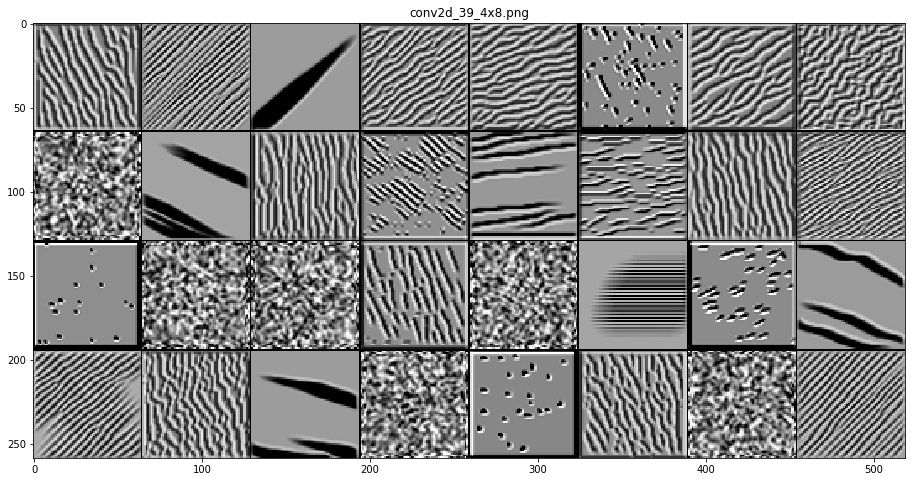

Compute filters 0 to 16
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 16 filter processed.
Filter Losses:  [8.579562, 14.255563, 8.7883415, 10.892591, 11.964811, 19.470152, 13.521259, 10.509993, 17.42694, 7.0332317, 19.558031, 10.583561, 10.405777, 10.527503, 3.1549587, 8.848161]


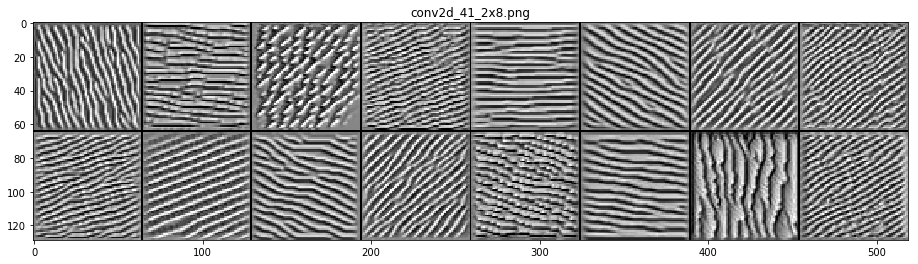

In [17]:
visualize_layer(model,model.layers[0].name,filter_range=(0,32),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

visualize_layer(model,model.layers[3].name,filter_range=(0,16),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

### Without Custom Loss [Winner - 99.52%]

In [23]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.2))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) #12

model.add(Convolution2D(16, 3,3, activation='relu')) # 10
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.15))
model.add(Convolution2D(16, 3,3, activation='relu')) #6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu')) #6
model.add(Convolution2D(10, 6,6))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=1)
es = EarlyStopping("val_acc",patience=15,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.005,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=512, epochs=50, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)



Params =  12846

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0007999999448657036.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0003199999686330557.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.00012799998512491584.
Layer Names:  ['conv2d_61', 'dropout_29', 'conv2d_62', 'conv2d_63', 'dropout_30', 'max_pooling2d_13', 'conv2d_64', 'dropout_31', 'conv2d_65', 'dropout_32', 'conv2d_66', 'dropout_33', 'conv2d_67', 'conv2d_68', 'flatten_9', 'activation_9']
Validation Loss (0.02025147004276514, 0.9945999999046325)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  12846
Score =  [0.004682400778581359, 0.9989833333333333]
Balanced Accuracy = 99.90% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  12846
Score =  [0.0189475956565

Compute filters 0 to 32
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 32 filter processed.
Filter Losses:  [5.3510413, 3.160671, 5.859011, 3.8760529, 3.4767768, 9.267539, 3.1471112, 3.9024038, 3.1863556, 5.6294446, 3.1668465, 7.413015, 4.190792, 4.94872, 2.0645874, 5.840909, 5.180309, 6.569014, 2.7987816, 7.9387546, 5.6939535, 7.7193613, 3.011123, 7.443647, 7.1321898, 8.957219, 5.1663013, 3.6494737, 7.8549266, 3.662958, 0.0, 4.0827603]


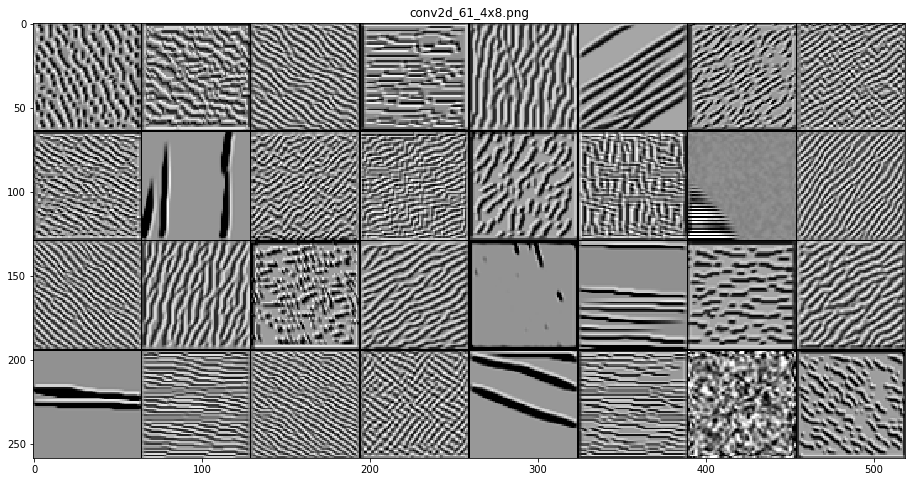

Compute filters 0 to 16
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 16 filter processed.
Filter Losses:  [10.64121, 15.835657, 17.24326, 9.050956, 6.2047286, 22.733824, 9.1385145, 43.06436, 16.330244, 31.197426, 23.144688, 13.066068, 12.135147, 16.786825, 6.3634443, 12.425097]


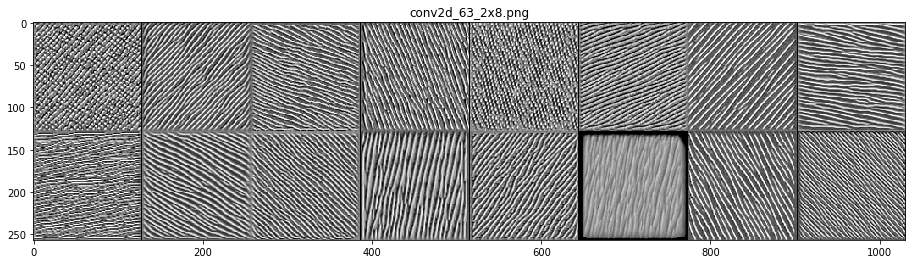

In [24]:
visualize_layer(model,model.layers[0].name,filter_range=(0,32),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

visualize_layer(model,model.layers[3].name,filter_range=(0,16),upscaling_steps=20,
                    upscaling_factor=1.05,
                    output_dim=(128, 128),step=0.5,epochs=40)

## Architecture 4
- 8->16 architecture
- Low number of Params

### With Custom Loss

In [8]:

model = Sequential()

model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2))) # 12
model.add(Convolution2D(8, 3,3, activation='relu')) # 10
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.25))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 6,6))



model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0001,verbose=0)
es = EarlyStopping("val_acc",patience=30,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
optimizer = Adam(lr=0.001,)

model.compile(loss=combined_smoothness_diversity_loss(model,categorical_crossentropy,1,256,X_train.shape[0],
                                       diversity_constant=0.0001,smoothness_constant=0,
                                       diversity_clipping=0.1,
                                       diversity_decay=5, smoothness_decay=None,),
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=256, epochs=150, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.53%


Params =  10972
Layer Names:  ['conv2d_9', 'dropout_6', 'conv2d_10', 'dropout_7', 'max_pooling2d_2', 'conv2d_11', 'dropout_8', 'conv2d_12', 'dropout_9', 'conv2d_13', 'dropout_10', 'conv2d_14', 'dropout_11', 'conv2d_15', 'flatten_2', 'activation_2']
Validation Loss (0.021234676691005008, 0.993)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.008055026008043205, 0.9978833333333333]
Balanced Accuracy = 99.79% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.017254965766635724, 0.9945]
Balanced Accuracy = 99.44% 


Compute filters 0 to 8
  0   1   2   3   4   5   6   7 8 filter processed.
Filter Losses:  [3.1489978, 3.1160634, 2.8921428, 2.2899365, 2.9725602, 2.9962072, 3.160818, 2.6047251]


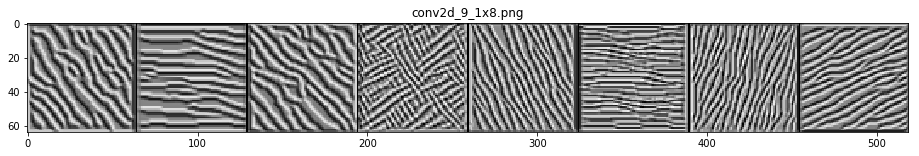

Compute filters 0 to 16
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 16 filter processed.
Filter Losses:  [2.1194654, 4.1770444, 3.9589741, 3.5665407, 2.1262753, 1.1341091, 3.51664, 3.5940533, 3.494478, 2.1746044, 4.4538565, 3.9601073, 1.6501719, 3.6995745, 4.7884517, 4.5949965]


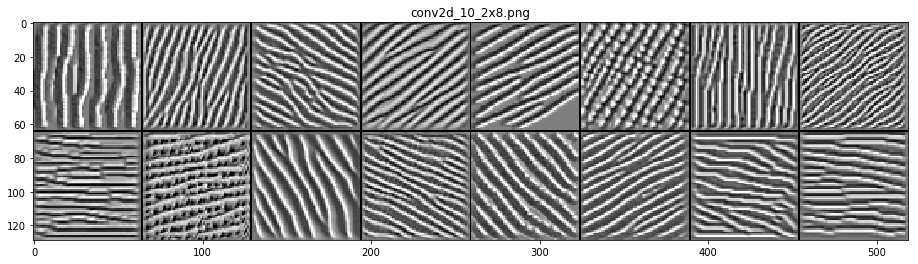

In [9]:
visualize_layer(model,model.layers[0].name,filter_range=(0,8),upscaling_steps=10,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=10)

visualize_layer(model,model.layers[2].name,filter_range=(0,16),upscaling_steps=10,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=10)

### Without Custom Loss

In [11]:

model = Sequential()

model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 24
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2))) # 12
model.add(Convolution2D(8, 3,3, activation='relu')) # 10
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 8
model.add(Dropout(0.25))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(16, 3,3, activation='relu')) # 6
model.add(Dropout(0.1))
model.add(Convolution2D(10, 6,6))



model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=0.0001,verbose=0)
es = EarlyStopping("val_acc",patience=30,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
optimizer = Adam(lr=0.001,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=256, epochs=150, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)

# 99.46%


Params =  10972
Layer Names:  ['conv2d_22', 'dropout_19', 'conv2d_23', 'dropout_20', 'max_pooling2d_4', 'conv2d_24', 'dropout_21', 'conv2d_25', 'dropout_22', 'conv2d_26', 'dropout_23', 'conv2d_27', 'dropout_24', 'conv2d_28', 'flatten_4', 'activation_4']
Validation Loss (0.023570079044648445, 0.9932)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.00720692309770869, 0.9979666666666667]
Balanced Accuracy = 99.79% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  10972
Score =  [0.020720217430405318, 0.9947]
Balanced Accuracy = 99.46% 


Compute filters 0 to 8
  0   1   2   3   4   5   6   7 8 filter processed.
Filter Losses:  [5.4457984, 6.4946084, 6.9133844, 5.953564, 0.0, 6.9546065, 5.9721437, 3.9599333]


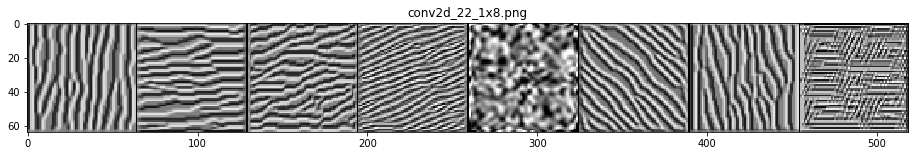

Compute filters 0 to 16
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 16 filter processed.
Filter Losses:  [12.548154, 11.9342785, 7.2633305, 3.8378763, 2.809908, 9.558328, 5.5417724, 10.395354, 2.667092, 5.611893, 7.442, 4.8239436, 2.5434227, 4.3283825, 6.0476584, 6.583655]


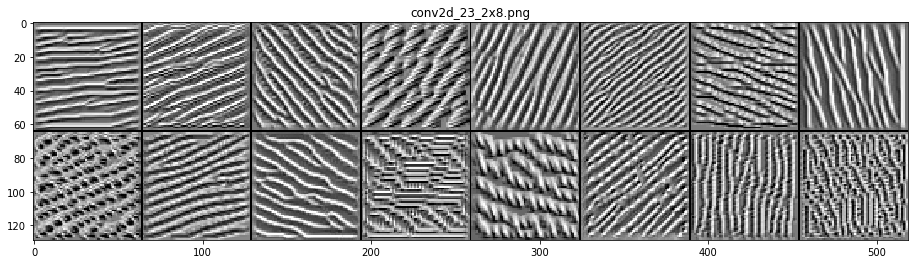

In [12]:
visualize_layer(model,model.layers[0].name,filter_range=(0,8),upscaling_steps=10,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

visualize_layer(model,model.layers[2].name,filter_range=(0,16),upscaling_steps=10,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

## Architecture 16

### Without Custom Loss

In [18]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.1))
model.add(Convolution2D(12, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12


model.add(Convolution2D(8, (3,3,), activation='relu')) # 10
model.add(Dropout(0.1))
model.add(Convolution2D(12, (3,3,), activation='relu')) # 8
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=0)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=512, epochs=150, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  4430
Layer Names:  ['conv2d_50', 'dropout_37', 'conv2d_51', 'dropout_38', 'conv2d_52', 'max_pooling2d_11', 'conv2d_53', 'dropout_39', 'conv2d_54', 'dropout_40', 'conv2d_55', 'dropout_41', 'max_pooling2d_12', 'conv2d_56', 'flatten_8', 'activation_8']
Validation Loss (0.025276528361439704, 0.9911999997138977)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  4430
Score =  [0.014646915259538219, 0.99615]
Balanced Accuracy = 99.61% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  4430
Score =  [0.025791404234850778, 0.9913]
Balanced Accuracy = 99.12% 


In [19]:
sl,cl,sf = view_layer_filter_stats(0)
print(sl,cl)

14.727285385131836 0.3921181


Compute filters 0 to 8
  0   1   2   3   4   5   6   7 8 filter processed.
Filter Losses:  [11.368083, 6.0732765, 8.296818, 4.690989, 12.688718, 7.665552, 0.0, 6.0577736]


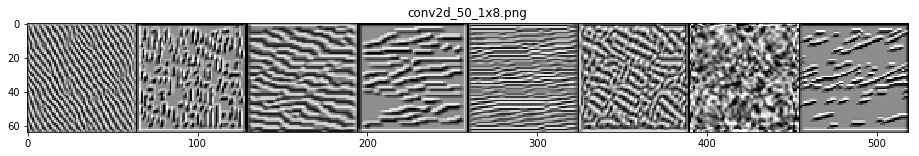

Compute filters 0 to 12
  0   1   2   3   4   5   6   7   8   9  10  11 12 filter processed.
Filter Losses:  [16.614096, 29.45761, 20.204943, 6.2069564, 15.111333, 18.5705, 7.184656, 0.0, 16.197954, 8.076864, 20.057325, 16.70172]


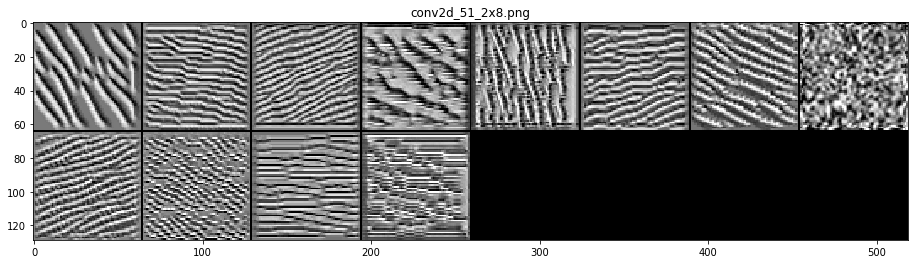

In [20]:
visualize_layer(model,model.layers[0].name,filter_range=(0,8),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

visualize_layer(model,model.layers[2].name,filter_range=(0,12),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

### With Custom Loss

In [80]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(Dropout(0.1))
model.add(Convolution2D(12, 3,3, activation='relu')) # 24
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12


model.add(Convolution2D(8, (3,3,), activation='relu')) # 10
model.add(Dropout(0.1))
model.add(Convolution2D(12, (3,3,), activation='relu')) # 8
model.add(Dropout(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=4, min_lr=0.0001,verbose=0)
es = EarlyStopping("val_acc",patience=35,restore_best_weights=True)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [es,checkpoint,reduce_lr]
optimizer = Adam(lr=0.01,)

model.compile(loss=combined_smoothness_diversity_loss(model,categorical_crossentropy,1,256,X_train.shape[0],
                                       diversity_constant=0.0001,smoothness_constant=0,
                                       diversity_clipping=0.01,
                                       diversity_decay=5, smoothness_decay=None,),
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=512, epochs=150, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  4430
Layer Names:  ['conv2d_267', 'dropout_125', 'conv2d_268', 'dropout_126', 'conv2d_269', 'max_pooling2d_68', 'conv2d_270', 'dropout_127', 'conv2d_271', 'dropout_128', 'conv2d_272', 'max_pooling2d_69', 'conv2d_273', 'flatten_39', 'activation_39']
Validation Loss (0.02242773992419243, 0.9934999999046326)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  4430
Score =  [0.014571803063705252, 0.99595]
Balanced Accuracy = 99.59% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  4430
Score =  [0.022782499897293747, 0.9941]
Balanced Accuracy = 99.40% 


Compute filters 0 to 8
  0   1   2   3   4   5   6   7 8 filter processed.
Filter Losses:  [8.14639, 6.0259, 6.323995, 10.481482, 7.425544, 5.5867176, 4.8084583, 5.25892]


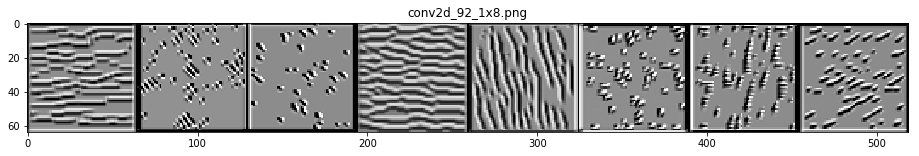

Compute filters 0 to 12
  0   1   2   3   4   5   6   7   8   9  10  11 12 filter processed.
Filter Losses:  [16.953926, 16.553709, 15.321224, 15.271867, 9.809681, 12.401783, 22.52033, 16.8714, 17.813, 17.062174, 24.153809, 23.036114]


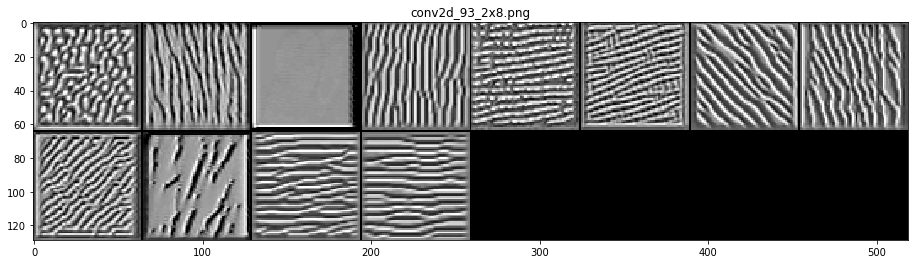

In [34]:
visualize_layer(model,model.layers[0].name,filter_range=(0,8),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

visualize_layer(model,model.layers[2].name,filter_range=(0,12),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)

In [35]:
sl,cl,sf = view_layer_filter_stats(0)
print(sl,cl)

9.963409423828125 0.368136


## Architecture 17 SpatialDropout2D in initial 2 layers only [x]

- Compare this to Architecture 15: Without Custom Loss
- SpatialDropout2D is useful only in initial layers where pixels are highly correlated to each other in the same channel

In [10]:
model = Sequential()
model.add(Convolution2D(8, 3, 3, activation='relu', input_shape=(28,28,1))) # 26
model.add(SpatialDropout2D(0.1))
model.add(Convolution2D(12, 3,3, activation='relu')) # 24
model.add(SpatialDropout2D(0.1))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12


model.add(Convolution2D(8, (3,3,), activation='relu')) # 10
model.add(Dropout(0.05))
model.add(Convolution2D(12, (3,3,), activation='relu')) # 8
model.add(Dropout(0.05))
model.add(Convolution2D(10, 1, activation='relu'))
model.add(Dropout(0.05))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(10, 4,4))

model.add(Flatten())
model.add(Activation('softmax'))
print("Params = ",model.count_params())

checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=10, min_lr=0.0001,verbose=0)

callbacks_list = [checkpoint,reduce_lr]
optimizer = Adam(lr=0.002,)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

train_history = model.fit(X_train, Y_train, batch_size=512, epochs=200, verbose=0, shuffle=True, validation_data=(X_test, Y_test), callbacks=callbacks_list,)
print("Layer Names: ",[layer.name for layer in model.layers[0:]])
val_metrics = (train_history.history['val_loss'][-1],train_history.history['val_acc'][-1])
print("Validation Loss",val_metrics)

model.load_weights("model.hdf5")

_=evaluate(model,X_train, Y_train,classes=get_mnist_labels(),print_results=True, plot_results=False)
_=evaluate(model,X_test, Y_test,classes=get_mnist_labels(),print_results=True, plot_results=False)


Params =  4430
Layer Names:  ['conv2d_16', 'spatial_dropout2d_1', 'conv2d_17', 'spatial_dropout2d_2', 'conv2d_18', 'max_pooling2d_3', 'conv2d_19', 'dropout_12', 'conv2d_20', 'dropout_13', 'conv2d_21', 'dropout_14', 'max_pooling2d_4', 'conv2d_22', 'flatten_3', 'activation_3']
Validation Loss (0.025067787289619444, 0.9921999997138977)
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  4430
Score =  [0.012207131879053002, 0.9967666666666667]
Balanced Accuracy = 99.67% 
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Total Model Params =  4430
Score =  [0.02437266396987252, 0.9925]
Balanced Accuracy = 99.24% 


Compute filters 0 to 8
  0   1   2   3   4   5   6   7 8 filter processed.
Filter Losses:  [9.681639, 5.7172728, 9.992807, 10.636131, 6.725895, 8.528169, 15.328926, 11.554985]


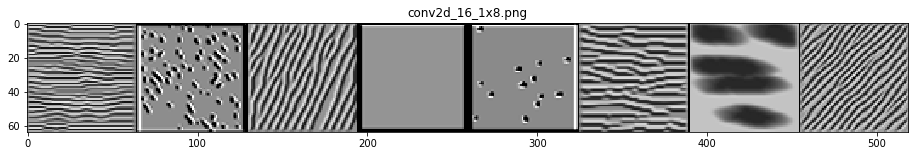

Compute filters 0 to 12
  0   1   2   3   4   5   6   7   8   9  10  11 12 filter processed.
Filter Losses:  [19.386408, 8.682347, 13.658142, 21.595175, 8.78671, 22.418571, 19.14121, 40.164333, 8.30844, 14.960228, 5.5670843, 16.71749]


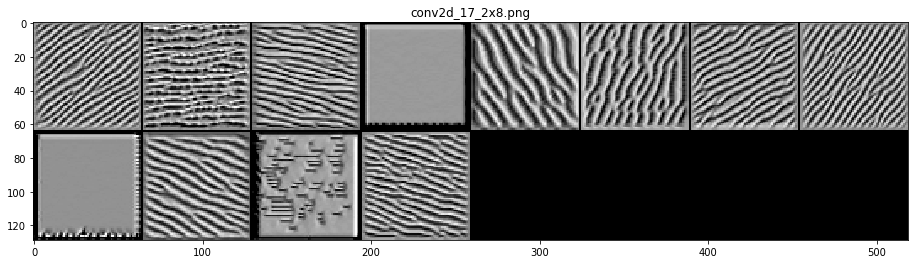

In [11]:
visualize_layer(model,model.layers[0].name,filter_range=(0,8),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)
visualize_layer(model,model.layers[2].name,filter_range=(0,12),upscaling_steps=5,
                    upscaling_factor=1.05,
                    output_dim=(64, 64),step=0.5,epochs=20)